# HVNM Tutorial 03: Stress Relaxation — NLSQ to NUTS

**Fit stress relaxation G(t) with the Hybrid Vitrimer Nanocomposite Model**

After a step strain $\gamma_0$, the HVNM relaxation modulus is:

$$G(t) = G_P X(\phi) + G_E e^{-2k_{BER}^{mat}t} + G_I X_I e^{-2k_{BER}^{int}t} + G_D e^{-k_d^D t}$$

The three exponential modes + equilibrium plateau constrain:
**G_P, G_E, G_D, nu_0** (controls k_BER), and **k_d_D**.

## Dataset
Liquid foam stress relaxation — G(t)

## Estimated Runtime
- NLSQ: ~10 s | NUTS: ~1 min (FAST_MODE) / ~10 min (production)

## 1. Setup

In [1]:
import sys
import time

IN_COLAB = "google.colab" in sys.modules
if IN_COLAB:
    %pip install -q rheojax openpyxl
    import os
    os.environ["JAX_ENABLE_X64"] = "true"

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from rheojax.core.jax_config import safe_import_jax, verify_float64
from rheojax.models import HVNMLocal

jax, jnp = safe_import_jax()
verify_float64()

sys.path.insert(0, "../..")
from examples.utils.hvnm_tutorial_utils import (
    configure_hvnm_for_fit,
    get_bayesian_config,
    get_fast_mode,
    get_nlsq_values,
    get_output_dir,
    load_foam_relaxation,
    plot_fit_comparison,
    plot_ppc,
    plot_trace_and_forest,
    print_convergence,
    print_parameter_table,
    save_figure,
    save_results,
    setup_style,
)

setup_style()
print(f"JAX {jax.__version__}, FAST_MODE: {get_fast_mode()}")
import os
import sys

sys.path.insert(0, os.path.dirname(os.path.abspath("")))
from utils.plotting_utils import (
    display_arviz_diagnostics,
    plot_nlsq_fit,
    plot_posterior_predictive,
)

JAX 0.8.3, FAST_MODE: True


## 2. Load Data and Apply QC

Protocol: relaxation
  Points: 200 / 200
  x range: [0.4023, 1399]
  y range: [4.545, 175.2]
  material: Liquid foam
  source: pyRheo demos
  units_x: s
  units_y: Pa


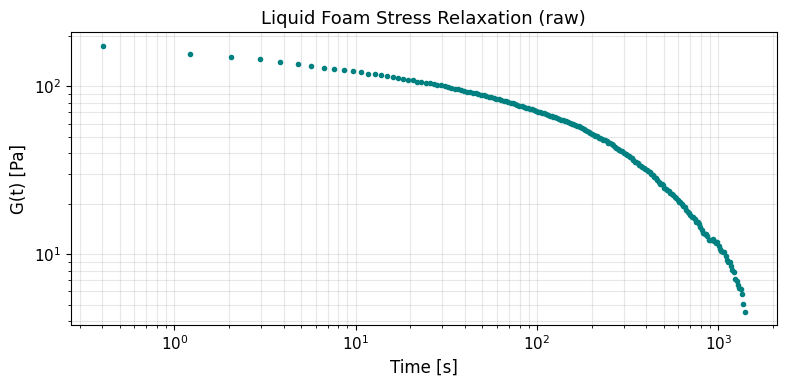

In [3]:
data = load_foam_relaxation(max_points=200)

print(data.summary())

fig, ax = plt.subplots(figsize=(8, 4))
ax.loglog(data.x_masked, data.y_masked, 'o', ms=3, color='teal')
ax.set_xlabel(data.x_label)
ax.set_ylabel(data.y_label)
ax.set_title('Liquid Foam Stress Relaxation (raw)')
ax.grid(True, alpha=0.3, which='both')
plt.tight_layout()
plt.show()

In [4]:
# Apply QC: exclude very early-time points (t < 0.1 s) where instrument
# inertia may contaminate the signal
early_cut = 0.1  # seconds
data.mask = data.x >= early_cut

# Check for monotonic decay (expected for relaxation)
y = data.y_masked
n_non_monotone = np.sum(np.diff(y) > 0)
print(f"Points after QC: {data.n_points}")
print(f"Non-monotone increments: {n_non_monotone} / {len(y)-1}")
if n_non_monotone > 0.1 * len(y):
    print("WARNING: >10% non-monotone. Check data quality or noise level.")
else:
    print("OK: data is predominantly monotone-decreasing.")

Points after QC: 200
Non-monotone increments: 5 / 199
OK: data is predominantly monotone-decreasing.


## 3. Configure HVNM and Fit (NLSQ)

The relaxation modulus constrains 5 HVNM parameters:
- **G_P**: Permanent network modulus (long-time plateau)
- **G_E**: Exchangeable network modulus (E-network relaxation mode)
- **G_D**: Dissociative network modulus (D-network relaxation mode)
- **nu_0**: BER attempt frequency (sets k_BER → E-network relaxation time)
- **k_d_D**: D-network dissociation rate

In [5]:
model = HVNMLocal(include_dissociative=True)
fit_params = configure_hvnm_for_fit(
    model,
    protocol="relaxation",
    overrides={
        "G_P": 50.0,      # Equilibrium plateau (~50 Pa for foam)
        "G_E": 100.0,     # Exchangeable contribution
        "G_D": 50.0,      # Dissociative contribution
        "nu_0": 1e8,      # Attempt frequency
        "k_d_D": 0.5,     # Dissociation rate
        "T": 300.0,       # Room temperature
        "phi": 0.0,       # No nanoparticles
    },
)
print(f"Fittable: {fit_params}")

t0 = time.time()
model.fit(
    data.x_masked,
    data.y_masked,
    test_mode="relaxation",
    use_log_residuals=True,
    max_iter=3000,
)
print(f"NLSQ: {time.time() - t0:.1f} s")

nlsq_vals = get_nlsq_values(model, fit_params)
for p, v in nlsq_vals.items():
    print(f"  {p} = {v:.4g}")

# Derived relaxation times
k_BER_0 = nlsq_vals['nu_0'] * np.exp(-80e3 / (8.314 * 300.0))
tau_E = 1.0 / (2.0 * k_BER_0)
tau_D = 1.0 / nlsq_vals['k_d_D']
print(f"\nDerived relaxation times:")
print(f"  tau_E = 1/(2*k_BER_0) = {tau_E:.4g} s")
print(f"  tau_D = 1/k_d_D = {tau_D:.4g} s")

INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=15 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


Fittable: ['G_P', 'G_E', 'G_D', 'nu_0', 'k_d_D']


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=1.897562s


INFO:nlsq.least_squares:Convergence reason=`xtol` termination condition is satisfied. | iterations=8 | final_cost=1.1589 | elapsed=1.898s | final_gradient_norm=1.1376e+05


NLSQ: 2.4 s
  G_P = 13.7
  G_E = 1.026e+06
  G_D = 8.801e+06
  nu_0 = 1.115e+10
  k_d_D = 22.99

Derived relaxation times:
  tau_E = 1/(2*k_BER_0) = 3813 s
  tau_D = 1/k_d_D = 0.0435 s


Figure saved: /Users/b80985/Projects/rheojax/examples/hvnm/../../examples/utils/../figures/hvnm/hvnm_03_relax_nlsq_fit.png


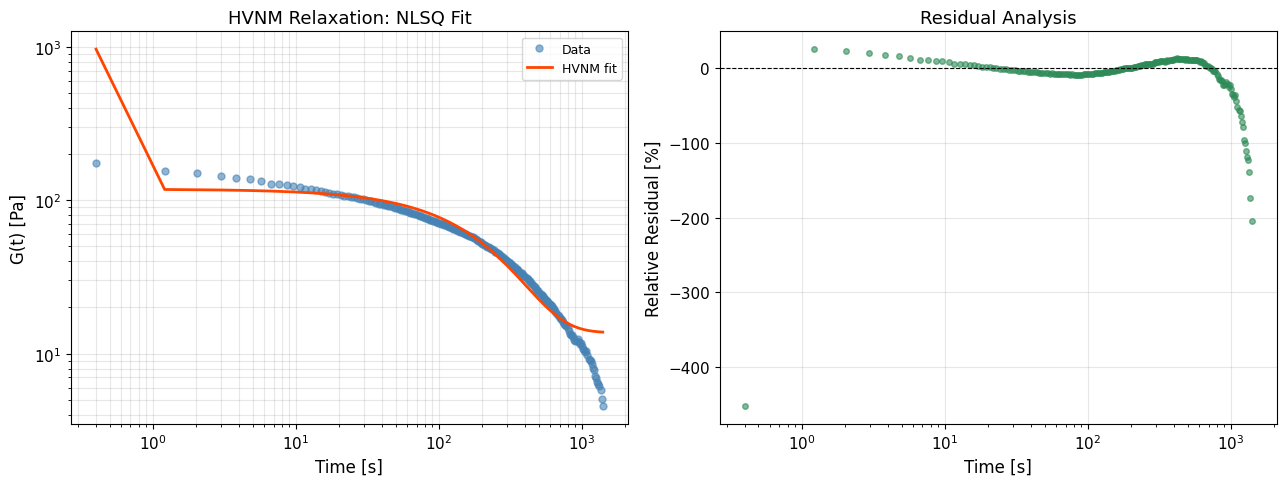

In [6]:
fig = plot_fit_comparison(data, model, title="HVNM Relaxation: NLSQ Fit")
save_figure(fig, "hvnm_03_relax_nlsq_fit.png")
plt.show()

## 4. Bayesian Inference (NUTS)

In [7]:
bayes_cfg = get_bayesian_config()
print(f"Config: {bayes_cfg}")

t0 = time.time()
result = model.fit_bayesian(
    data.x_masked,
    data.y_masked,
    test_mode="relaxation",
    **bayes_cfg,
)
print(f"NUTS: {time.time() - t0:.1f} s")

Config: {'num_warmup': 50, 'num_samples': 100, 'num_chains': 1}


  0%|          | 0/150 [00:00<?, ?it/s]

warmup:   1%|          | 1/150 [00:01<03:23,  1.37s/it, 1 steps of size 1.95e+00. acc. prob=0.00]

warmup:  19%|█▉        | 29/150 [00:01<00:04, 27.05it/s, 255 steps of size 1.01e-03. acc. prob=0.79]

warmup:  31%|███       | 46/150 [00:01<00:02, 43.79it/s, 255 steps of size 1.95e-02. acc. prob=0.82]

sample:  42%|████▏     | 63/150 [00:01<00:01, 61.94it/s, 255 steps of size 1.44e-02. acc. prob=0.82]

sample:  53%|█████▎    | 80/150 [00:01<00:00, 78.79it/s, 255 steps of size 1.44e-02. acc. prob=0.91]

sample:  65%|██████▌   | 98/150 [00:01<00:00, 98.15it/s, 255 steps of size 1.44e-02. acc. prob=0.89]

sample:  77%|███████▋  | 116/150 [00:01<00:00, 114.95it/s, 255 steps of size 1.44e-02. acc. prob=0.90]

sample:  89%|████████▉ | 134/150 [00:02<00:00, 129.77it/s, 255 steps of size 1.44e-02. acc. prob=0.89]

sample: 100%|██████████| 150/150 [00:02<00:00, 68.70it/s, 255 steps of size 1.44e-02. acc. prob=0.89] 

NUTS: 5.0 s


## 5. Diagnostics and PPC

In [8]:
print_convergence(result, fit_params)
print()
print_parameter_table(fit_params, nlsq_vals, result.posterior_samples)

Convergence Diagnostics
   Parameter     R-hat       ESS
--------------------------------------------------
         G_P    0.9978        48 *
         G_E    1.1454         6 *
         G_D    1.0024        28 *
        nu_0    1.2267        10 *
       k_d_D    1.0334        21 *

Divergences: 2
Convergence: CHECK REQUIRED

Parameter Comparison
       Param          NLSQ    Bayes(med)                    95% CI
------------------------------------------------------------------
         G_P          13.7         14.02  [12.07, 15.44]
         G_E     1.026e+06     7.072e+06  [1.202e+06, 2.016e+07]
         G_D     8.801e+06     5.313e+07  [2.781e+06, 9.257e+07]
        nu_0     1.115e+10     4.481e+10  [4.885e+09, 2.511e+11]
       k_d_D         22.99          34.2  [27.11, 36.12]


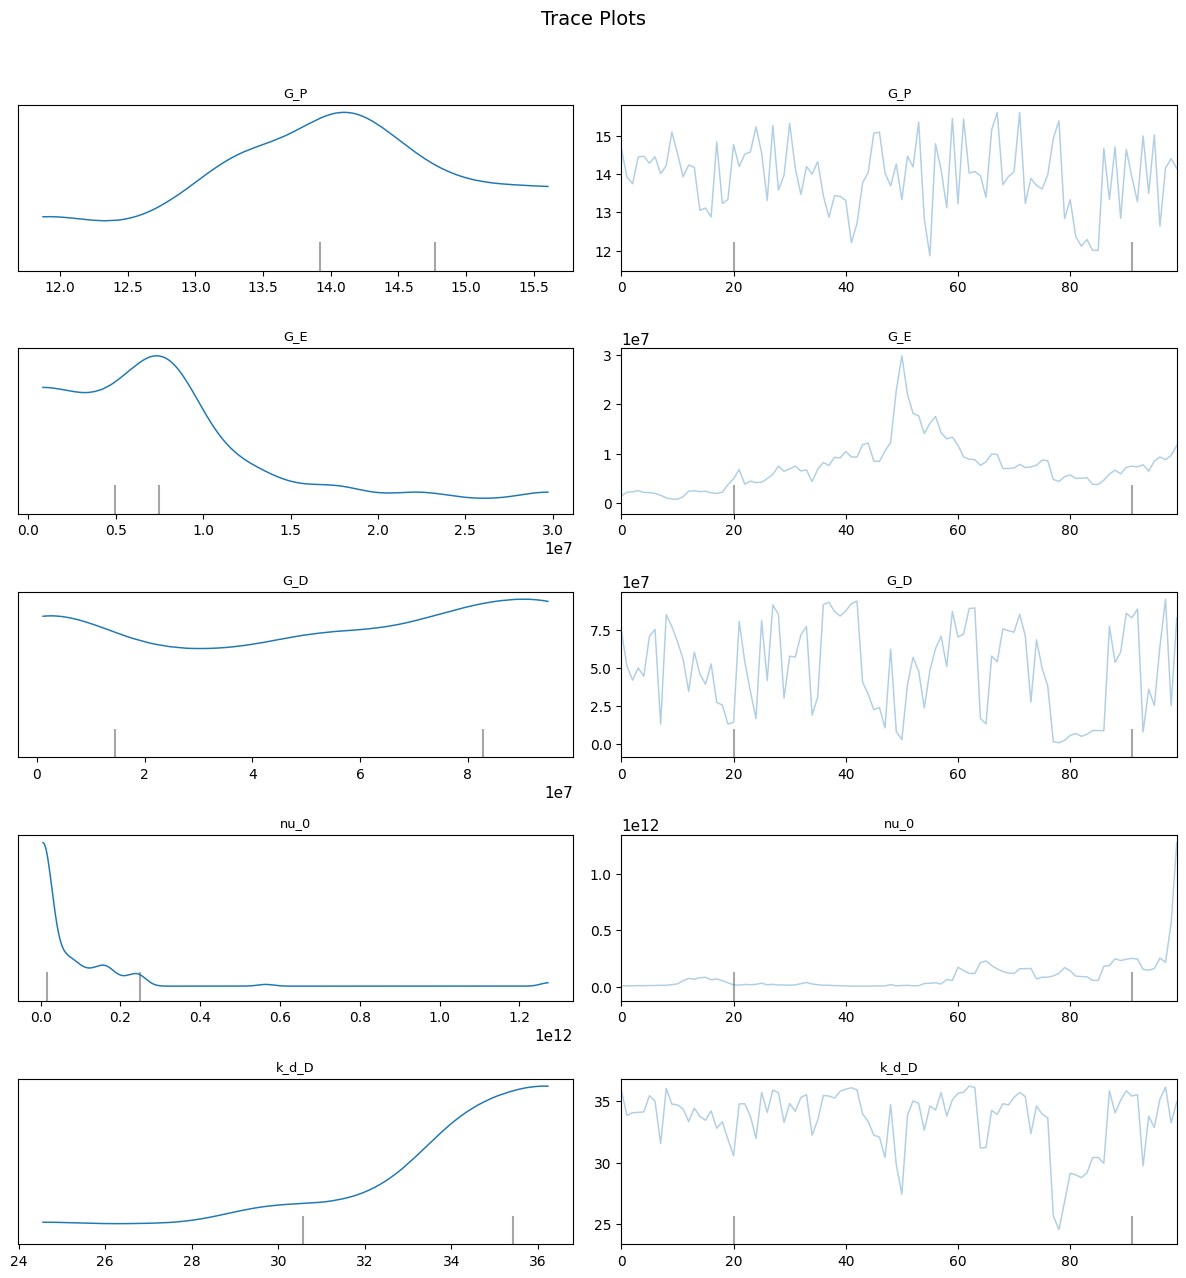

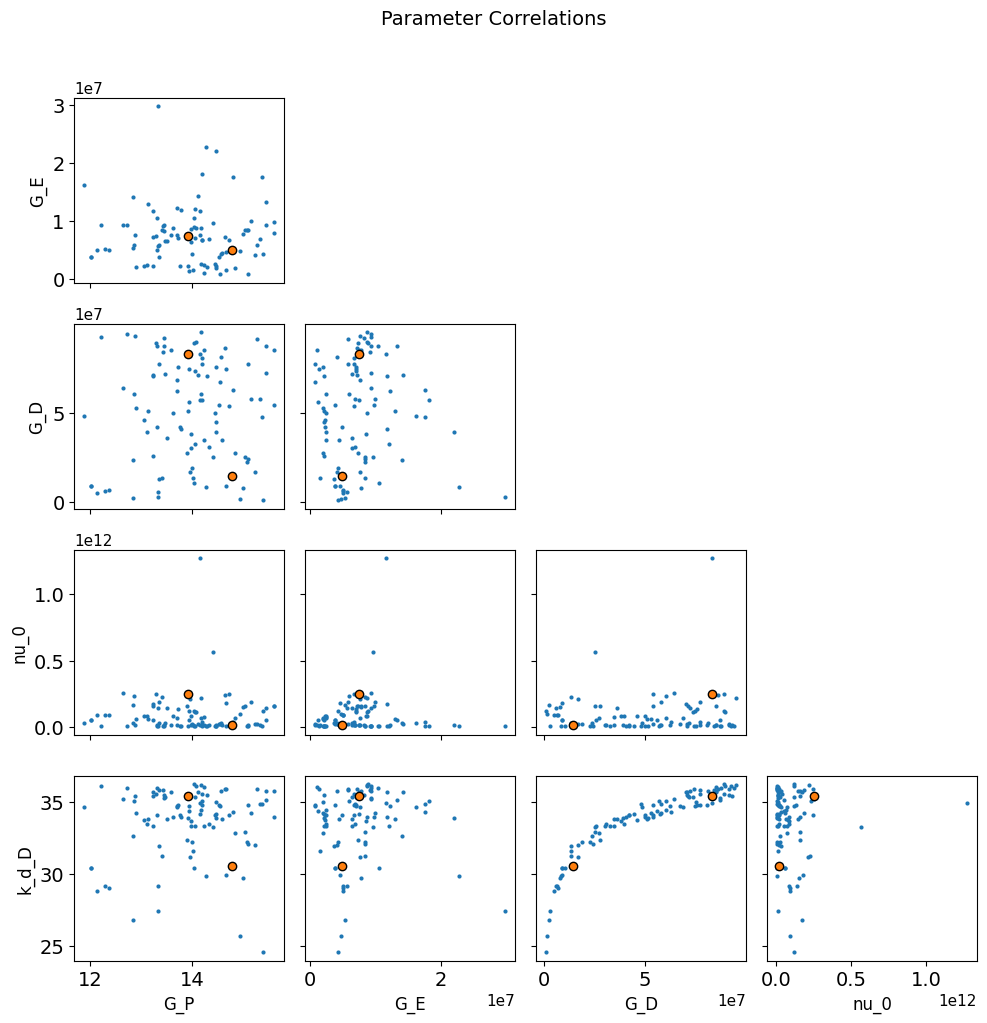

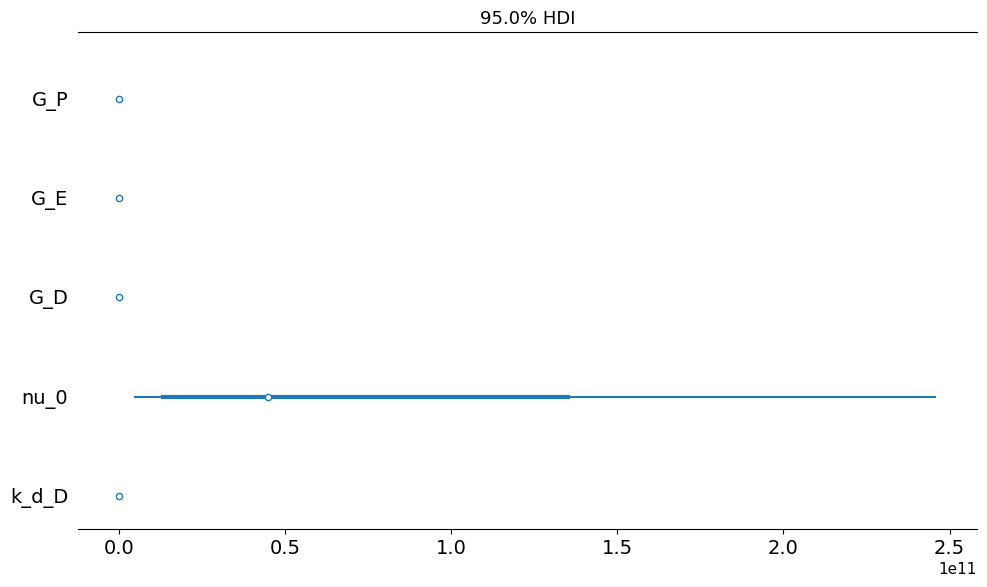

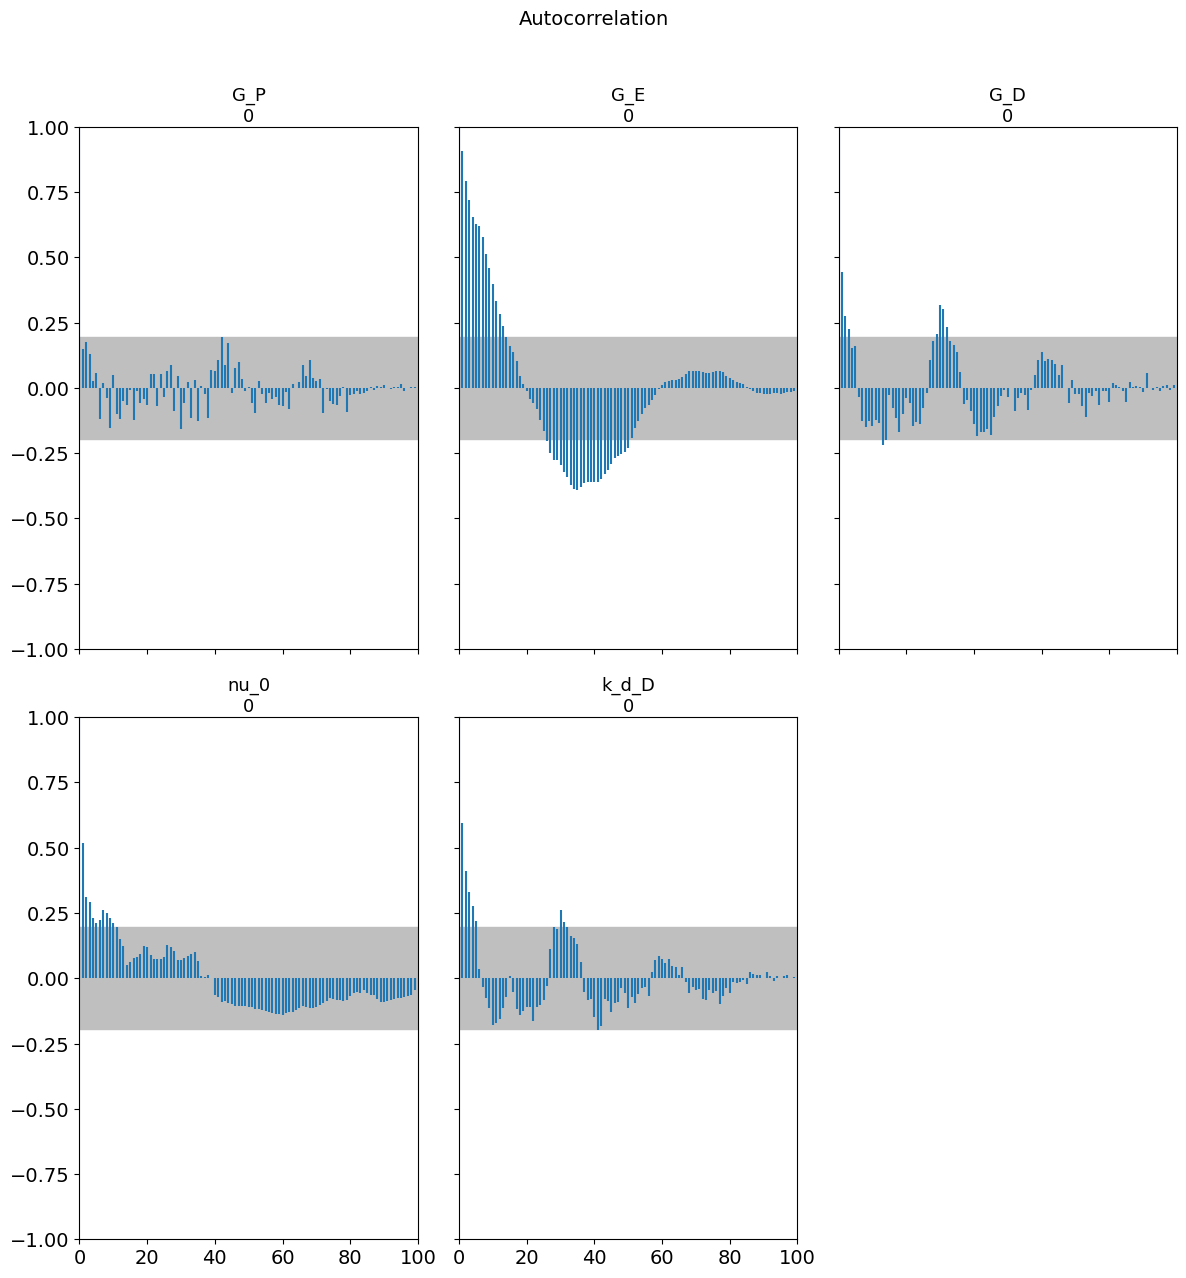

In [9]:
display_arviz_diagnostics(result, fit_params, fast_mode=get_fast_mode())

Figure saved: /Users/b80985/Projects/rheojax/examples/hvnm/../../examples/utils/../figures/hvnm/hvnm_03_relax_ppc.png


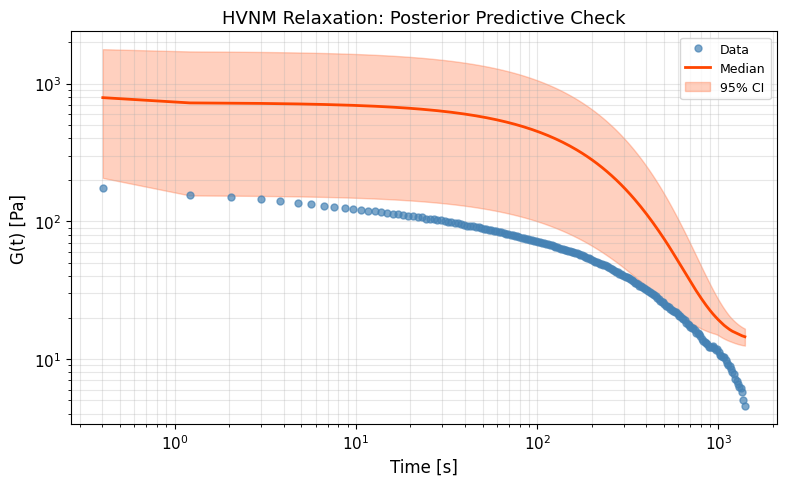

In [10]:
fig = plot_ppc(
    data, model, result.posterior_samples, fit_params,
    title="HVNM Relaxation: Posterior Predictive Check",
)
save_figure(fig, "hvnm_03_relax_ppc.png")
plt.show()

## 6. Save Results

In [11]:
save_results(
    get_output_dir("relaxation"), model, result,
    param_names=fit_params,
    extra_meta={"dataset": "liquid_foam", "protocol": "relaxation"},
)

Saved to /Users/b80985/Projects/rheojax/examples/hvnm/../../examples/utils/../outputs/hvnm/relaxation/


## What to Change for Your Data

1. **G(t) vs σ(t)**: If you have stress σ(t) instead of modulus G(t), divide by the step strain γ₀
2. **Early-time cut**: Adjust `early_cut` to exclude instrument ringing or inertial artifacts
3. **Temperature**: Update `T` override (in Kelvin) to match your experiment
4. **Nanoparticles**: Set `phi > 0` to enable Guth-Gold reinforcement X(φ)
5. **Log-space residuals**: `use_log_residuals=True` is critical for relaxation data spanning decades

## Troubleshooting

- **G(t) not decaying**: Check that `nu_0` initial guess is in the right ballpark (τ_E = 1/(2*k_BER_0) should be within the experimental time window)
- **Flat long-time plateau**: G_P sets the equilibrium modulus. If your material flows (no plateau), set G_P → 0
- **Underfitting at short times**: The D-network provides the fast relaxation mode. Increase `k_d_D` initial guess
- **G_E and nu_0 correlation**: Both control the E-network relaxation time. Add SAOS data (notebook 05) to break the degeneracy
- **Negative modulus predictions**: Ensure all G_P, G_E, G_D bounds are ≥ 0